# Introduction

In this notebook, I will be leveraging foursquare location data to explore venues districts in Delhi, India. This will give me insights of what most popular venues are there in each district and the quantity/quality of data that Foursquare has of India.

#### Import required libraries

In [1]:
import requests

from bs4 import BeautifulSoup

import pandas as pd

import numpy as np

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install folium
import folium # map rendering library

On exploring internet, I found a blog which has information on all the PostalCodes of Delhi, which mentions district and corresponding neighborhoods as well. I will be reading the required information from the website. 
www.whatsuplife.in/delhi/blog/zip-pin-postal-code-pincodes-delhi

In [ ]:
# Read the HTML page
reponse = requests.get('https://www.whatsuplife.in/delhi/blog/zip-pin-postal-code-pincodes-delhi')
soup = BeautifulSoup(reponse.content, 'html.parser')

Get all the Districts

In [3]:
headings = soup.findAll("h4")
districts = []
for heading in headings:
     if heading.findParent("h4") is None:
        districts.append(str(heading.text).replace(u'\xa0', u' '))
districts

['CENTRAL DELHI',
 'SOUTH DELHI',
 'WEST DELHI',
 'NORTH DELHI',
 'EAST DELHI',
 'SOUTH WEST DELHI',
 'NORTH WEST DELHI']

In [8]:
# Define the delhi dataframe
delhi_df = pd.DataFrame(columns=['District','Neighborhood', 'PostalCode'])

Read all the districts, postal codes and corresponding neighborhoods from the HTML

In [9]:
tables = soup.findAll("table")
for table, district in zip(tables, districts):
    trs = table.find_all('tr')
    trs = [tr for tr in trs if len(tr.find_all('td')) == 2]
    neighborhoods = []
    postalcodes = []
    dis = []
    for tr in trs:
        tds = tr.find_all('td')
        postalcodes.append(tds[1].text)
        neighborhoods.append(tds[0].text)
        dis.append(district)
    df = pd.DataFrame(list(zip(dis, neighborhoods, postalcodes)), columns=['District','Neighborhood', 'PostalCode'])
    delhi_df = delhi_df.append(df)
    
print("The shape of delhi dataframe ", delhi_df.shape)

The shape of delhi dataframe  (425, 3)


In [10]:
# Read first five rows
delhi_df.head()

,District,Neighborhood,PostalCode
0,CENTRAL DELHI,A.G.c.r.,110002
1,CENTRAL DELHI,A.K.market,110055
2,CENTRAL DELHI,Ajmeri Gate extn.,110002
3,CENTRAL DELHI,Anand Parbat,110005
4,CENTRAL DELHI,Anand Parbat indl. area,110005


As you can see above, there are mulitple neighborhoods in same PostalCode and same District.

Below I will check the unique counts of each

In [11]:
delhi_df.describe()

,District,Neighborhood,PostalCode
count,425,425,425
unique,7,424,84
top,SOUTH DELHI,Shivaji Park,110001
freq,77,2,19


So there are 7 Unique Districts, 424 Unique Neighborhoods and 84 Unique PostalCodes

Now lets join the neihborhoods, based on common PostalCode so that we have list of neighborhoods in one cell that correspond to a PostalCode

In [14]:
strjoin = lambda x: ', '.join(set(x))
agg_functions = {'District': 'first', 'Neighborhood': strjoin, 'PostalCode': 'first'}
agg_functions

{'District': 'first',
 'Neighborhood': <function __main__.<lambda>(x)>,
 'PostalCode': 'first'}

In [16]:
delhi_cleaned_df = delhi_df.groupby(delhi_df['PostalCode']).aggregate(agg_functions)
delhi_cleaned_df = delhi_cleaned_df.reset_index(drop=True)
delhi_cleaned_df.head()

,District,Neighborhood,PostalCode
0,CENTRAL DELHI,"Connaught Place, Bengali Market, Janpath, Nort...",110001
1,CENTRAL DELHI,"Indraprastha, Gandhi Smarak nidhi, Darya Ganj,...",110002
2,CENTRAL DELHI,"Pandara Road, Pragati Vihar, Delhi High court,...",110003
3,CENTRAL DELHI,Rashtrapati Bhawan,110004
4,CENTRAL DELHI,"Bank Street, Sat Nagar, Desh Bandhu gupta road...",110005


Check again for unique counts

In [17]:
delhi_cleaned_df.describe()

,District,Neighborhood,PostalCode
count,84,84,84
unique,7,84,84
top,SOUTH WEST DELHI,"Daulatpur, Baprola, Dichaoal Kalan, Dulsiras, ...",110062
freq,22,1,1


I will use Nominatim library to get Latitude, Longitude of each PostalCode in Delhi

In [18]:
locator = Nominatim(user_agent='myGeocoder')
location = locator.geocode('Delhi, India')
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Delhi are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Delhi are 28.6517178, 77.2219388.


In [ ]:
# Since this does not work all the time, it is better to save the data when successfully retrieved.
from time import sleep

def get_lat_lon(postal_code):
    location = locator.geocode('{}, Delhi, India'.format(postal_code))
    sleep(2)
    return (location.latitude, location.longitude)

ll_df = pd.DataFrame(columns=['PostalCode', 'Latitude', 'Longitude'])

pcodes = []
lat_list = []
lon_list = []

for postal_code in delhi_cleaned_df['PostalCode']:
    lat, lon = get_lat_lon(postal_code)
    pcodes.append(postal_code)
    lat_list.append(lat)
    lon_list.append(lon)

In [ ]:
ll_df['PostalCode'] = pcodes
ll_df['Latitude'] = lat_list
ll_df['Longitude'] = lon_list

In [32]:
#if above is not a success
ll_df = pd.read_csv('Postcode_lat_lon.csv', index_col=0)
ll_df.head()

,PostalCode,Latitude,Longitude
0,110002,28.640964,77.245468
1,110055,28.652506,77.213391
2,110005,28.650529,77.189018
3,110001,28.651718,77.221939
4,110008,28.656175,77.162460


Add these to delhi dataframe

In [37]:
delhi_cleaned_df['PostalCode'] = delhi_cleaned_df.PostalCode.astype(int)

In [38]:
delhi_cleaned_df = delhi_cleaned_df.join(ll_df.set_index('PostalCode'), on='PostalCode')

In [39]:
delhi_cleaned_df.head()

,District,Neighborhood,PostalCode,Latitude,Longitude
0,CENTRAL DELHI,"Connaught Place, Bengali Market, Janpath, Nort...",110001,28.651718,77.221939
1,CENTRAL DELHI,"Indraprastha, Gandhi Smarak nidhi, Darya Ganj,...",110002,28.640964,77.245468
2,CENTRAL DELHI,"Pandara Road, Pragati Vihar, Delhi High court,...",110003,28.598731,77.222996
3,CENTRAL DELHI,Rashtrapati Bhawan,110004,28.616082,77.204501
4,CENTRAL DELHI,"Bank Street, Sat Nagar, Desh Bandhu gupta road...",110005,28.650529,77.189018


Save this file to use in Part 2

In [40]:
delhi_cleaned_df.to_csv("Delhi.csv")

In [52]:
delhi_cleaned_df.groupby('District')['District'].count()

District
CENTRAL DELHI       12
EAST DELHI          10
NORTH DELHI          3
NORTH WEST DELHI    14
SOUTH DELHI         13
SOUTH WEST DELHI    22
WEST DELHI          10
Name: District, dtype: int64

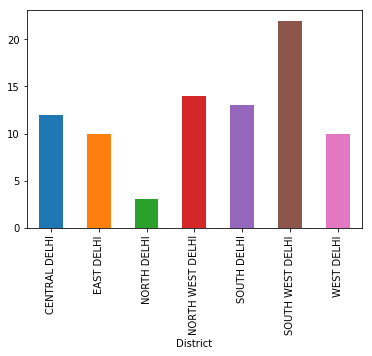

In [54]:
delhi_cleaned_df.groupby('District')['District'].count().plot.bar()

Create a map of delhi with all the postalcodes/neighborhoods

In [55]:
# create map of Delhi using latitude and longitude values
map_delhi = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, district, neighborhood in zip(delhi_cleaned_df['Latitude'], delhi_cleaned_df['Longitude'], delhi_cleaned_df['District'], delhi_cleaned_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_delhi)  
    
map_delhi

I will be using the above obtained data to figure out the venue data that foursquare has and can we find some insights among different districts of Delhi.

### Part 2

Prepare to use Foursquare API

In [100]:
CLIENT_ID = '*************************' # your Foursquare ID
CLIENT_SECRET = '*************************' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100

In [67]:
# Define function to get nearby venues from Foursquare "Venues Explore" API
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name, " fetched")
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Fetch top 100 venues from each Postal Code

In [68]:
delhi_venues = getNearbyVenues(names=delhi_cleaned_df['PostalCode'],
                                  latitudes=delhi_cleaned_df['Latitude'],
                                  longitudes=delhi_cleaned_df['Longitude'])

110001  fetched
110002  fetched
110003  fetched
110004  fetched
110005  fetched
110006  fetched
110007  fetched
110008  fetched
110009  fetched
110010  fetched
110011  fetched
110012  fetched
110013  fetched
110014  fetched
110015  fetched
110016  fetched
110017  fetched
110018  fetched
110019  fetched
110020  fetched
110021  fetched
110023  fetched
110024  fetched
110025  fetched
110026  fetched
110027  fetched
110028  fetched
110029  fetched
110030  fetched
110031  fetched
110032  fetched
110033  fetched
110034  fetched
110035  fetched
110036  fetched
110037  fetched
110038  fetched
110039  fetched
110040  fetched
110041  fetched
110042  fetched
110043  fetched
110044  fetched
110045  fetched
110047  fetched
110048  fetched
110049  fetched
110051  fetched
110052  fetched
110053  fetched
110054  fetched
110055  fetched
110058  fetched
110059  fetched
110060  fetched
110061  fetched
110062  fetched
110063  fetched
110064  fetched
110065  fetched
110067  fetched
110068  fetched
110069  

In [69]:
# Print number of venues fetched
print("Number of venues fetched for 84 PostalCodes are :", delhi_venues.shape[0])

Number of venues fetched for 84 PostalCodes are : 409


In [70]:
# Read the dataframe
delhi_venues.head()

,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,110002,28.640964,77.245468,National Gandhi Museum,28.638919,77.245926,History Museum
1,110002,28.640964,77.245468,Feroz Shah Kotla Stadium | फिरोज शाह कोटला स्ट...,28.637907,77.241869,Cricket Ground
2,110002,28.640964,77.245468,"Ansari Road, Daryaganj",28.642258,77.241534,Road
3,110003,28.598731,77.222996,L'Opera,28.599784,77.226144,Café
4,110003,28.598731,77.222996,SODABOTTLEOPENERWALA,28.600141,77.226273,Irani Cafe


In [71]:
print('There are {} uniques categories for 84 postal codes'.format(len(delhi_venues['Venue Category'].unique())))

There are 99 uniques categories for 84 postal codes


### Prepare data for Analysis

Step 1 Decide on the venues returned

In [78]:
delhi_venues.groupby('PostalCode')['Venue Category'].nunique()

PostalCode
110002     3
110003    23
110004     2
110005    12
110006     8
110007     4
110008     1
110009     2
110013     4
110014     5
110015     3
110016     7
110017     7
110018     1
110019     4
110020    20
110021     5
110023     6
110024    13
110025     6
110026     5
110027    11
110029     4
110030     6
110031     2
110032     1
110033     1
110034     4
110036     2
110037     7
          ..
110049     5
110051     2
110053     2
110054     6
110055     2
110058     3
110059     2
110060     6
110062     2
110063     5
110064     5
110065     2
110067     3
110068     5
110069    20
110071     1
110075     3
110076    18
110077     2
110078     2
110083     2
110084     1
110087     4
110088     1
110091     1
110092     7
110093     1
110094     1
110095     3
110096     1
Name: Venue Category, Length: 68, dtype: int64

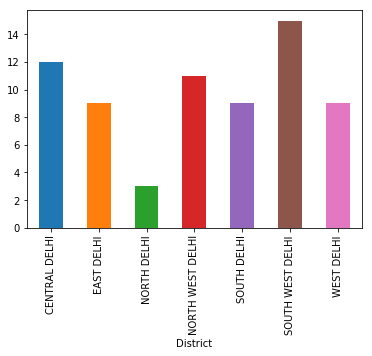

In [84]:
delhi_venues['District'] = delhi_cleaned_df['District']
delhi_venues.groupby('District')['Venue Category'].nunique().plot.bar()

As you can see above, postal codes does not give good data of unique categories, on the other hand with District wise unique venues is ok with minimum 3 different categories for North West Delhi. Hence I will be using district wise venues data for further analysis

Step 2 One Hot Encoding

In [90]:
# one hot encoding
delhi_onehot = pd.get_dummies(delhi_venues[['Venue Category']], prefix="", prefix_sep="")

# add  District column back to dataframe
delhi_onehot['District'] = delhi_venues['District']

In [92]:
# move postalcode and district column to the front
cols = list(delhi_onehot)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('District')))
delhi_onehot = delhi_onehot.reindex(columns= cols)

delhi_onehot.head()

,District,ATM,Airport Food Court,American Restaurant,Arcade,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,...,Shopping Plaza,Snack Place,Soccer Field,South Indian Restaurant,Spa,Spiritual Center,Sporting Goods Shop,Thai Restaurant,Train Station,Women's Store
0,CENTRAL DELHI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CENTRAL DELHI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CENTRAL DELHI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CENTRAL DELHI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CENTRAL DELHI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Step 3 Group by District wise on the mean

In [93]:
delhi_grouped = delhi_onehot.groupby('District').mean().reset_index()
delhi_grouped

,District,ATM,Airport Food Court,American Restaurant,Arcade,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,...,Shopping Plaza,Snack Place,Soccer Field,South Indian Restaurant,Spa,Spiritual Center,Sporting Goods Shop,Thai Restaurant,Train Station,Women's Store
0,CENTRAL DELHI,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,EAST DELHI,0.2,0.0,0.000000,0.0,0.100000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,NORTH DELHI,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,NORTH WEST DELHI,0.0,0.0,0.071429,0.0,0.071429,0.0,0.000000,0.000000,0.071429,...,0.0,0.071429,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,SOUTH DELHI,0.0,0.0,0.000000,0.0,0.000000,0.0,0.153846,0.076923,0.076923,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
5,SOUTH WEST DELHI,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.136364,0.0,0.0,0.0,0.045455,0.0,0.0,0.0,0.0
6,WEST DELHI,0.0,0.0,0.000000,0.0,0.100000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Step 4 Print top 3 venues for each district

In [94]:
num_top_venues = 3

for district in delhi_grouped['District']:
    print("----"+district+"----")
    temp = delhi_grouped[delhi_grouped['District'] == district].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----CENTRAL DELHI----
               venue  freq
0        Pizza Place  0.08
1               Café  0.08
2  Indian Restaurant  0.08


----EAST DELHI----
                 venue  freq
0                  ATM   0.2
1                 Café   0.1
2  Fried Chicken Joint   0.1


----NORTH DELHI----
               venue  freq
0  Food & Drink Shop  0.33
1     Breakfast Spot  0.33
2               Café  0.33


----NORTH WEST DELHI----
                  venue  freq
0                  Café  0.14
1  Fast Food Restaurant  0.14
2        Breakfast Spot  0.14


----SOUTH DELHI----
               venue  freq
0  Indian Restaurant  0.23
1          BBQ Joint  0.15
2               Café  0.15


----SOUTH WEST DELHI----
                venue  freq
0         Snack Place  0.14
1                Café  0.09
2  Chinese Restaurant  0.09


----WEST DELHI----
                 venue  freq
0    Indian Restaurant   0.2
1  Japanese Restaurant   0.1
2     Asian Restaurant   0.1




Step 5 Arrange these in a dataframe

In [95]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = delhi_grouped['District']

for ind in np.arange(delhi_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)

district_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,CENTRAL DELHI,Cricket Ground,Road,Indian Restaurant
1,EAST DELHI,ATM,Fried Chicken Joint,Diner
2,NORTH DELHI,Breakfast Spot,Food & Drink Shop,Café
3,NORTH WEST DELHI,Café,Breakfast Spot,Fast Food Restaurant
4,SOUTH DELHI,Indian Restaurant,Café,BBQ Joint
5,SOUTH WEST DELHI,Snack Place,Café,Chinese Restaurant
6,WEST DELHI,Indian Restaurant,Dessert Shop,Hotel


As you can see from above analysis - Central Delhi, North Delhi and North West Delhi top three venues have the same frequency, therefore the results in Step 4 and Step 5 are ambiguous. This proves the Foursquare API does not have enough "good" data for Delhi to perform analysis.

Let's try K-means clustring on this data

In [96]:
# set number of clusters
kclusters = 5

delhi_grouped_clustering = delhi_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(delhi_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 2, 1, 4, 0, 0])

In [97]:
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

delhi_merged = delhi_cleaned_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
delhi_merged = delhi_merged.join(district_venues_sorted.set_index('District'), on='District')

delhi_merged.head()

,District,Neighborhood,PostalCode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,CENTRAL DELHI,"Connaught Place, Bengali Market, Janpath, Nort...",110001,28.651718,77.221939,0,Cricket Ground,Road,Indian Restaurant
1,CENTRAL DELHI,"Indraprastha, Gandhi Smarak nidhi, Darya Ganj,...",110002,28.640964,77.245468,0,Cricket Ground,Road,Indian Restaurant
2,CENTRAL DELHI,"Pandara Road, Pragati Vihar, Delhi High court,...",110003,28.598731,77.222996,0,Cricket Ground,Road,Indian Restaurant
3,CENTRAL DELHI,Rashtrapati Bhawan,110004,28.616082,77.204501,0,Cricket Ground,Road,Indian Restaurant
4,CENTRAL DELHI,"Bank Street, Sat Nagar, Desh Bandhu gupta road...",110005,28.650529,77.189018,0,Cricket Ground,Road,Indian Restaurant


Put these clusters on the Map

In [99]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(delhi_merged['Latitude'], delhi_merged['Longitude'], delhi_merged['District'], delhi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Conclusion

Using foursquare api data, I tried to explore different postalcodes of Delhi, but the data was very limited, therefore I switched to districts and analyzed the venues available.
During analysis of top venues in district, I found out the data is ambiguous also which can be seen while comparing step 4 and step 5. 

#### Lesson learnt
This notebook is a very good reference and start point for me to further pursue exploration of Delhi, India from other data sources like google places api, and may be some local places providers.